<a href="https://colab.research.google.com/github/MengOonLee/Deep_learning/blob/master/PyTorch/Experiments/Transformer/TimeSeries/Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from pathlib import Path
from sklearn import model_selection

def generate_data(data_path, num_steps, interval=0.1):
    np.random.seed(seed=42)
    x = np.linspace(start=0, stop=num_steps * interval, num=num_steps)
    y = np.sin(x) + np.random.normal(loc=0, scale=0.1, size=x.shape)
    np.savez(file=data_path, y=y)

data_path = 'data.npz'
generate_data(data_path=data_path, num_steps=1000000)

def load_and_partition_data(data_path, seq_length=100):

    data = np.load(data_path)
    num_features = len(data.keys())

    data_lens = [len(data[key]) for key in data.keys()]
    assert len(set(data_lens)) == 1

    num_sequences = data_lens[0] // seq_length
    sequences = np.empty(shape=(num_sequences, seq_length, num_features))

    for i in range(0, num_sequences):
        sample = np.asarray(a=[data[key][i * seq_length : (i + 1) * seq_length]
            for key in data.keys()]
        ).swapaxes(0, 1)
        sequences[i] = sample
    return sequences, num_features

sequences, num_features = load_and_partition_data('data.npz')
seq_train, seq_test = model_selection.train_test_split(sequences, test_size=0.2,
    random_state=42)

seq_train.shape

(8000, 100, 1)

In [ ]:
import numpy as np
import torch

class SeqDataset(torch.utils.data.Dataset):
    def __init__(self, seqs, ratio=0.8):
        super().__init__()
        self.seqs = seqs
        self.ratio = ratio

    def __len__(self):
        return len(self.seqs)

    def __getitem__(self, idx):
        seq = self.seqs[idx]
        src_end = int(seq.shape[0] * self.ratio)
        src = torch.tensor(data=seq[:src_end], dtype=torch.float32)
        tgt = torch.tensor(data=seq[src_end - 1 : -1], dtype=torch.float32)
        tgt_y = torch.tensor(data=seq[src_end:], dtype=torch.float32)
        return src, tgt, tgt_y

dl_train = torch.utils.data.DataLoader(dataset=SeqDataset(seqs=seq_train),
    batch_size=512, shuffle=True)
dl_test = torch.utils.data.DataLoader(dataset=SeqDataset(seqs=seq_test),
    batch_size=512, shuffle=False)
len(dl_train), len(dl_test)

(16, 4)

In [ ]:
import torch
import numpy as np

class PositionalEncoding(torch.nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super().__init__()
        self.dropout = torch.nn.Dropout(p=dropout)
        position = torch.arange(end=max_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(torch.arange(start=0, end=d_model, step=2).float()
            * (-np.log(10000.0) / d_model))
        pe = torch.zeros(size=(1, max_len, d_model))
        pe[0, :, 0::2] = torch.sin(position * div_term)
        pe[0, :, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

class TransformerWithPE(torch.nn.Module):
    def __init__(self, in_dim, out_dim, d_model, nhead, num_layers):
        super().__init__()
        self.encoder_embedding = torch.nn.Linear(in_features=in_dim,
            out_features=d_model)
        self.decoder_embedding = torch.nn.Linear(in_features=out_dim,
            out_features=d_model)
        self.positional_encoding = PositionalEncoding(d_model=d_model)

        self.transformer = torch.nn.Transformer(d_model=d_model, nhead=nhead,
            num_encoder_layers=num_layers, num_decoder_layers=num_layers,
            batch_first=True)

        self.output_layer = torch.nn.Linear(in_features=d_model,
            out_features=out_dim)

    def forward(self, src, tgt):
        src = self.encoder_embedding(src)
        src = self.positional_encoding(src)

        tgt_mask = torch.nn.Transformer.generate_square_subsequent_mask(
            sz=tgt.shape[1])

        tgt = self.decoder_embedding(tgt)
        tgt = self.positional_encoding(tgt)

        pred = self.transformer(src=src, tgt=tgt, tgt_mask=tgt_mask)
        pred = self.output_layer(pred)
        return pred

    def infer(self, src, tgt_len):
        output = torch.zeros(size=(src.shape[0], tgt_len + 1, src.shape[2]))\
            .to(src.device)
        output[:, 0] = src[:, -1]
        for i in range(tgt_len):
            output[:, i + 1] = model.forward(src=src, tgt=output)[:, i]
        return output[:, 1:]

torch.manual_seed(seed=42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TransformerWithPE(in_dim=num_features, out_dim=num_features,
    d_model=128, nhead=8, num_layers=2
).to(device)

Training duration: 399.25s


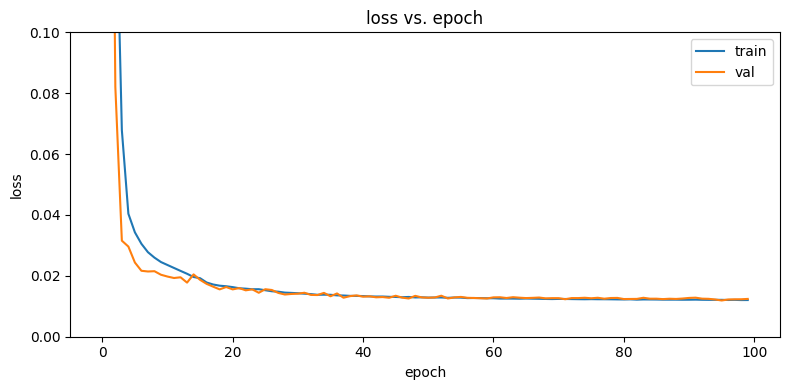

In [ ]:
import numpy as np
import torch
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def train_step(model, dl, criterion, optimizer):
    model.train()
    losses = []
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    for src, tgt, tgt_y in dl:
        src, tgt, tgt_y = src.to(device), tgt.to(device), tgt_y.to(device)
        y_pred = model(src=src, tgt=tgt)
        loss = criterion(input=y_pred, target=tgt_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    return np.mean(losses)

@torch.no_grad()
def test_step(model, dl, criterion):
    model.eval()
    losses = []
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    for src, tgt, tgt_y in dl:
        src, tgt, tgt_y = src.to(device), tgt.to(device), tgt_y.to(device)
        y_pred = model(src=src, tgt=tgt)
        loss = criterion(input=y_pred, target=tgt_y)
        losses.append(loss.item())
    return np.mean(losses)

def train_model(model, dl_train, dl_val, epochs):
    torch.manual_seed(seed=42)
    optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)
    criterion = torch.nn.MSELoss()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
        mode='min', factor=0.9, patience=3)

    history = {'train_loss': [], 'val_loss': []}
    for epoch in range(epochs):
        train_loss = train_step(model=model, dl=dl_train, criterion=criterion,
            optimizer=optimizer)
        history['train_loss'].append(train_loss)
        val_loss = test_step(model=model, dl=dl_val, criterion=criterion)
        history['val_loss'].append(val_loss)
        scheduler.step(val_loss)
    return model, history

start_time = time.time()
model, history = train_model(model=model, dl_train=dl_train, dl_val=dl_test,
    epochs=100)
print(f"Training duration: %.2fs"%(time.time() - start_time))

def plot_history(history):
    df_history = pd.DataFrame(history)
    df_history.index.name = 'epoch'
    df_history.reset_index(inplace=True)

    plt.figure(figsize=(8, 4))
    sns.lineplot(data=df_history, x='epoch', y='train_loss', label='train')
    sns.lineplot(data=df_history, x='epoch', y='val_loss', label='val')
    plt.legend(loc='best')
    plt.title(label=f'loss vs. epoch')
    plt.xlabel(xlabel='epoch')
    plt.ylabel(ylabel='loss')
    plt.ylim(bottom=0, top=0.1)
    plt.tight_layout()
    plt.show()

plot_history(history=history)

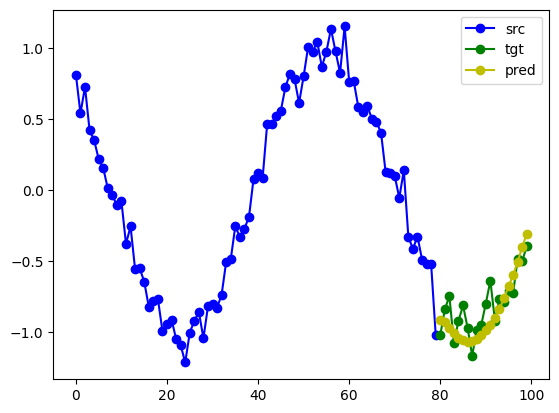

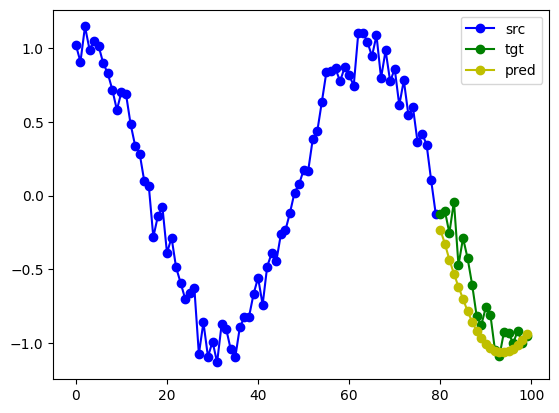

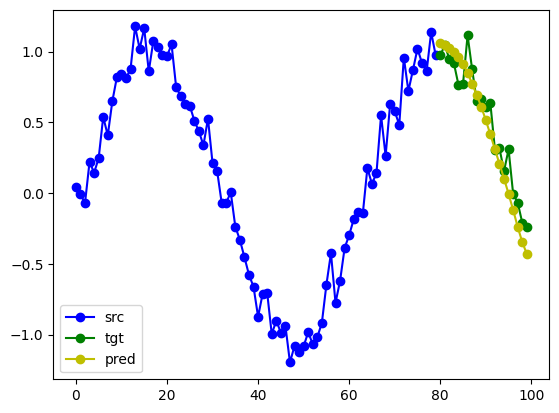

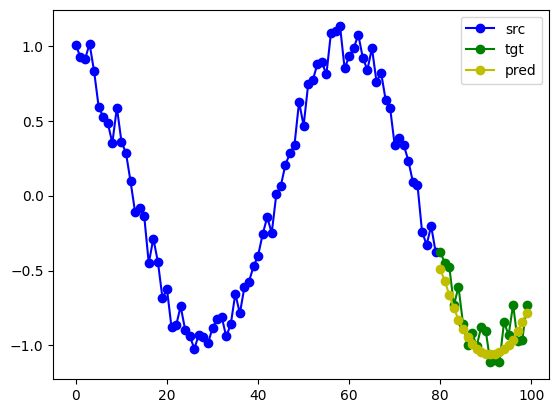

<Figure size 640x480 with 0 Axes>

In [ ]:
model.eval()
with torch.no_grad():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    for src, tgt, tgt_y in dl_test:
        src, tgt, tgt_y = src.to(device), tgt.to(device), tgt_y.to(device)
        y_pred = model.infer(src=src, tgt_len=tgt.shape[1])

        x = np.arange(src.shape[1] + tgt.shape[1])
        src_len = src.shape[1]
        idx = 0
        plt.plot(x[:src_len], src[idx].cpu().detach(), "bo-", label="src")
        plt.plot(x[src_len:], tgt[idx].cpu().detach(), "go-", label="tgt")
        plt.plot(x[src_len:], y_pred[idx].cpu().detach(), "yo-", label="pred")

        plt.legend()
        plt.show()
        plt.clf()

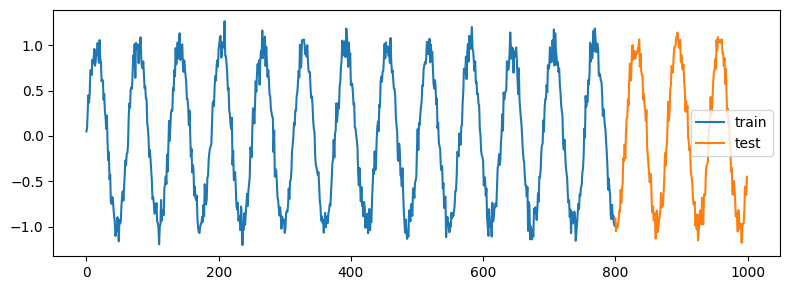

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def generate_ts(num_steps, interval=0.1):
    np.random.seed(seed=42)
    t = np.linspace(start=0, stop=num_steps * interval, num=num_steps)
    data = np.sin(t) + np.random.normal(loc=0, scale=0.1, size=t.shape)
    return data

ts = generate_ts(num_steps=1000)
ts_train, ts_test = ts[:-int(len(ts)*.2)], ts[-int(len(ts)*.2):]

plt.figure(figsize=(8, 3))
plt.plot(range(0, len(ts_train)), ts_train, label='train')
plt.plot(range(len(ts_train), len(ts)), ts_test, label='test')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import torch

def create_seqs(ts, in_window=24, out_window=12):
    seqs = []
    for i in range(len(ts) - (in_window + out_window) + 1):
        src = ts[i : i + in_window]
        tgt = ts[i + in_window -1 : i + in_window + out_window -1]
        tgt_y = ts[i + in_window : i + in_window + out_window]
        seqs.append((src, tgt, tgt_y))
    return seqs

seqs_train = create_seqs(ts=ts_train)
seqs_test = create_seqs(ts=ts_test)

class SeqsDataset(torch.utils.data.Dataset):
    def __init__(self, seqs):
        super().__init__()
        self.seqs = seqs

    def __len__(self):
        return len(self.seqs)

    def __getitem__(self, idx):
        src, tgt, tgt_y = self.seqs[idx]
        src = torch.tensor(data=src, dtype=torch.float32).view(-1, 1)
        tgt = torch.tensor(data=tgt, dtype=torch.float32).view(-1, 1)
        tgt_y = torch.tensor(data=tgt_y, dtype=torch.float32).view(-1, 1)
        return src, tgt, tgt_y

dl_train = torch.utils.data.DataLoader(dataset=SeqsDataset(seqs=seqs_train),
    batch_size=32, shuffle=True)
dl_test = torch.utils.data.DataLoader(dataset=SeqsDataset(seqs=seqs_test),
    batch_size=32, shuffle=False)
len(dl_train), len(dl_test)

(24, 6)

In [ ]:
import torch
import numpy as np

class PositionalEncoding(torch.nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super().__init__()
        self.dropout = torch.nn.Dropout(p=dropout)
        position = torch.arange(end=max_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(torch.arange(start=0, end=d_model, step=2).float()
            * (-np.log(10000.0) / d_model))
        pe = torch.zeros(size=(1, max_len, d_model))
        pe[0, :, 0::2] = torch.sin(position * div_term)
        pe[0, :, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

class TransformerWithPE(torch.nn.Module):
    def __init__(self, in_dim, out_dim, d_model, nhead, num_layers):
        super().__init__()
        self.encoder_embedding = torch.nn.Linear(in_features=in_dim,
            out_features=d_model)
        self.decoder_embedding = torch.nn.Linear(in_features=out_dim,
            out_features=d_model)
        self.positional_encoding = PositionalEncoding(d_model=d_model)

        self.transformer = torch.nn.Transformer(d_model=d_model, nhead=nhead,
            num_encoder_layers=num_layers, num_decoder_layers=num_layers,
            batch_first=True)

        self.output_layer = torch.nn.Linear(in_features=d_model,
            out_features=out_dim)

    def forward(self, src, tgt):
        src = self.encoder_embedding(src)
        src = self.positional_encoding(src)

        tgt_mask = torch.nn.Transformer.generate_square_subsequent_mask(
            sz=tgt.shape[1])

        tgt = self.decoder_embedding(tgt)
        tgt = self.positional_encoding(tgt)

        pred = self.transformer(src=src, tgt=tgt, tgt_mask=tgt_mask)
        pred = self.output_layer(pred)
        return pred

    def infer(self, src, tgt_len):
        output = torch.zeros(size=(src.shape[0], tgt_len + 1, src.shape[2]))\
            .to(src.device)
        output[:, 0] = src[:, -1]
        for i in range(tgt_len):
            output[:, i + 1] = model.forward(src=src, tgt=output)[:, i]
        return output[:, 1:]

torch.manual_seed(seed=42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TransformerWithPE(in_dim=1, out_dim=1,
    d_model=128, nhead=8, num_layers=2
).to(device)

Training duration: 778.44s


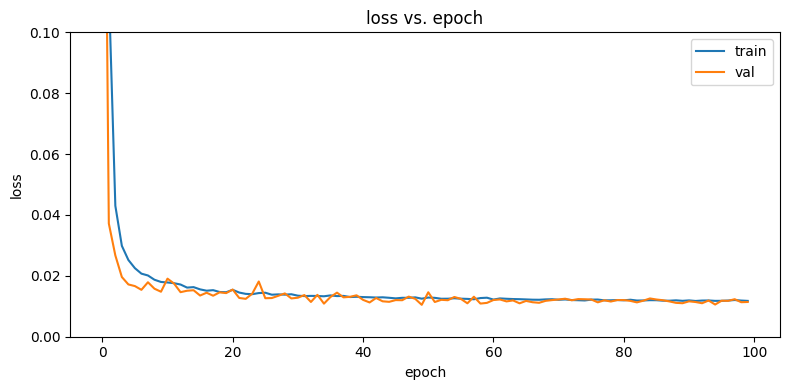

In [ ]:
import numpy as np
import torch
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def train_step(model, dl, criterion, optimizer):
    model.train()
    losses = []
    for src, tgt, tgt_y in dl:
        src, tgt, tgt_y = src.to(device), tgt.to(device), tgt_y.to(device)
        y_pred = model(src=src, tgt=tgt)
        loss = criterion(input=y_pred, target=tgt_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    return np.mean(losses)

@torch.no_grad()
def test_step(model, dl, criterion):
    model.eval()
    losses = []
    for src, tgt, tgt_y in dl:
        src, tgt, tgt_y = src.to(device), tgt.to(device), tgt_y.to(device)
        y_pred = model(src=src, tgt=tgt)
        loss = criterion(input=y_pred, target=tgt_y)
        losses.append(loss.item())
    return np.mean(losses)

def train_model(model, dl_train, dl_val, epochs):
    torch.manual_seed(seed=42)
    optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)
    criterion = torch.nn.MSELoss()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
        mode='min', factor=0.9, patience=3)

    history = {'train_loss': [], 'val_loss': []}
    for epoch in range(epochs):
        train_loss = train_step(model=model, dl=dl_train, criterion=criterion,
            optimizer=optimizer)
        history['train_loss'].append(train_loss)
        val_loss = test_step(model=model, dl=dl_val, criterion=criterion)
        history['val_loss'].append(val_loss)
        scheduler.step(val_loss)
    return model, history

start_time = time.time()
model, history = train_model(model=model, dl_train=dl_train, dl_val=dl_test,
    epochs=100)
print(f"Training duration: %.2fs"%(time.time() - start_time))

def plot_history(history):
    df_history = pd.DataFrame(history)
    df_history.index.name = 'epoch'
    df_history.reset_index(inplace=True)

    plt.figure(figsize=(8, 4))
    sns.lineplot(data=df_history, x='epoch', y='train_loss', label='train')
    sns.lineplot(data=df_history, x='epoch', y='val_loss', label='val')
    plt.legend(loc='best')
    plt.title(label=f'loss vs. epoch')
    plt.xlabel(xlabel='epoch')
    plt.ylabel(ylabel='loss')
    plt.ylim(bottom=0, top=0.1)
    plt.tight_layout()
    plt.show()

plot_history(history=history)

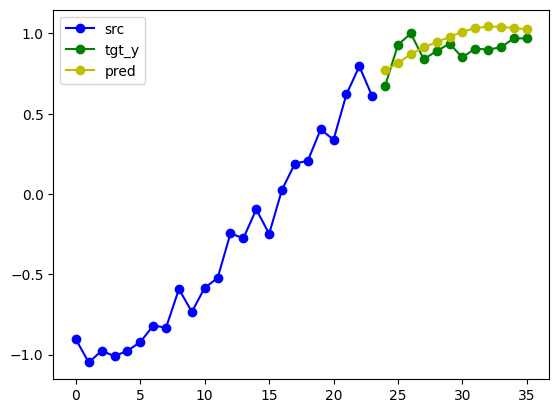

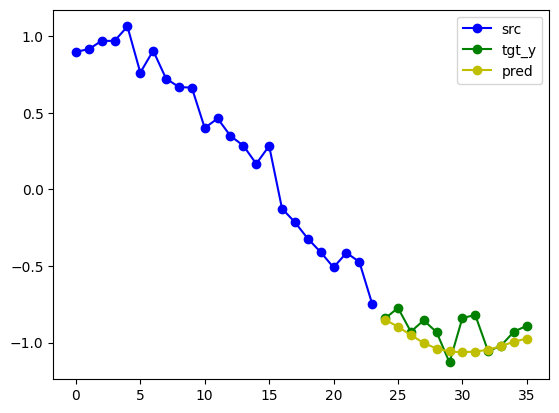

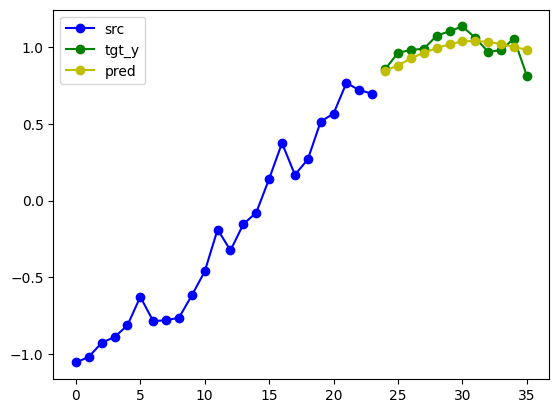

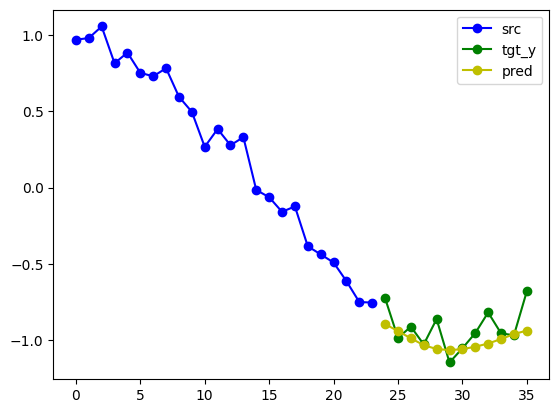

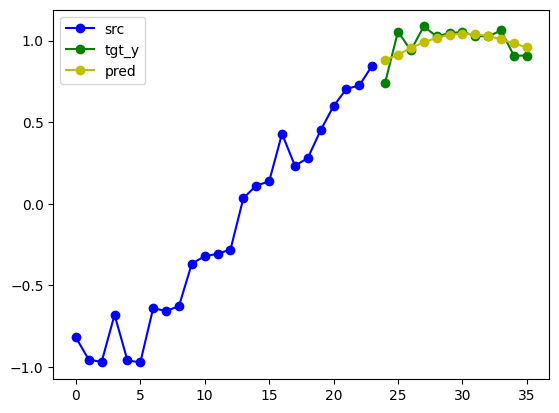

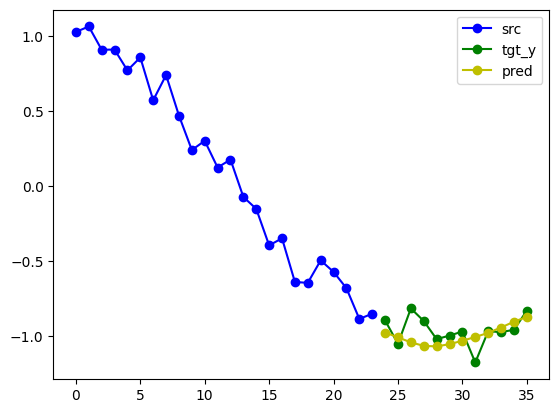

<Figure size 640x480 with 0 Axes>

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    for src, tgt, tgt_y in dl_test:
        src, tgt, tgt_y = src.to(device), tgt.to(device), tgt_y.to(device)
        y_pred = model.infer(src=src, tgt_len=tgt_y.shape[1])

        x = np.arange(src.shape[1] + tgt_y.shape[1])
        src_len = src.shape[1]
        idx = 0
        plt.plot(x[:src_len], src[idx].cpu().detach(), "bo-", label="src")
        plt.plot(x[src_len:], tgt_y[idx].cpu().detach(), "go-", label="tgt_y")
        plt.plot(x[src_len:], y_pred[idx].cpu().detach(), "yo-", label="pred")

        plt.legend()
        plt.show()
        plt.clf()